#### @Ayan Mitra, 2023
#
## This Notebook shows how we can 
### make additional diagonistics on the SN cosmosis analysis by testing the theory vectors individually, checking the chi square values, likelihoods etc.
### 
### 

In [66]:
! pwd

/pscratch/sd/a/ayanmitr/soft/firecrown/examples/srd_sn


In [43]:
import os
import sacc
import firecrown.likelihood.gauss_family.statistic.supernova as sn
from firecrown.likelihood.gauss_family.gaussian import ConstGaussian
from firecrown.modeling_tools import ModelingTools
import matplotlib.pyplot as plt
import pyccl as ccl
from sacc import Sacc
import numpy as np
import pandas as pd
import tarfile
import urllib.request
import datetime
import sys
import scipy.linalg
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')
import camb
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

In [55]:
def get_smoothed_curve(z_or, prediction, sigma, curve_type='lower', frac=0.05):
    """
    Get the smoothed curve based on the provided data and curve type.

    Parameters:
    - z_or: Original x-values.
    - prediction: Central prediction values.
    - sigma: Error values.
    - curve_type: String, either 'upper' or 'lower'. Specifies which curve to return.
    - frac: Fraction for lowess smoothing.

    Returns:
    - smoothed_curve: Array with two columns, the first being x-values and the second being y-values of the smoothed curve.
    """
    if curve_type == 'lower':
        prediction_curve = prediction - sigma
    elif curve_type == 'upper':
        prediction_curve = prediction + sigma
    else:
        raise ValueError("curve_type must be either 'upper' or 'lower'")

    f = interp1d(z_or, prediction_curve)

    new_z_or = np.linspace(min(z_or), max(z_or), 100)
    interpolated_values = f(new_z_or)
    smoothed_curve = lowess(interpolated_values, new_z_or.ravel(), frac=frac)

    return smoothed_curve


In [56]:
# For theory vectors : Path to chain file
path = "/pscratch/sd/a/ayanmitr/Results/SN_PLANCK_BAO/"
filename = path+'PUBLISHED/COSMOSIS-CHAINS/sn_planck_bao.txt'

In [57]:
# Data from sacc file
# Path to sacc file
saccfile = os.path.expanduser(os.path.expandvars(path+"srd-y1-converted.sacc"))
s = sacc.Sacc.load_fits(saccfile)

In [58]:
# Reading the lines
with open(filename, 'r') as file:
    lines = file.readlines()

# Step 2: Ignore lines that start with `#`.
cleaned_lines = [line.strip() for line in lines if not line.startswith('#')]

# Step 3: Read the remaining lines as a DataFrame.
# Get the first line as header and remaining lines as data
header = lines[0][1:-1].split('\t')
data = [line.split('\t') for line in cleaned_lines[1:]]

# Create DataFrame
df = pd.DataFrame(data, columns=header)

# Convert the data columns to the correct datatype (float)
for col in header:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.head(2)

,cosmological_parameters--omega_m,cosmological_parameters--h0,cosmological_parameters--w,cosmological_parameters--wa,firecrown_supernova_parameters--sn_ddf_sample_m,prior,post
0,0.310501,0.673106,-1.027712,-0.002797,-19.439019,0.579818,-915.117188
1,0.312009,0.676689,-1.077848,-0.107638,-19.450198,0.579818,-933.860703


### We choose only ~ 500 lines from the full chain file, to check and save time. 

In [59]:
print(np.shape(df))
# if it is so long for jupyter notebook to execute
# we can select every nth row to work with lesser number of 
# rows
df = df.iloc[::500, :]
print(np.shape(df))

(234538, 7)
(470, 7)


In [10]:
header

['cosmological_parameters--omega_m',
 'cosmological_parameters--h0',
 'cosmological_parameters--w',
 'cosmological_parameters--wa',
 'firecrown_supernova_parameters--sn_ddf_sample_m',
 'prior',
 'post']

In [60]:
def build_likelihood(_):
    """Build the Firecrown likelihood object. We have no extra tools for this
    example."""
    # Here we instantiate the necessary statistic object to deal with SNIa data.
    snia_stats = sn.Supernova(sacc_tracer="sn_ddf_sample")

    # Here we instantiate the actual likelihood. The statistics argument carry
    # the order of the data/theory vector.
    lk = ConstGaussian(statistics=[snia_stats])

    #    We load the correct SACC file.
    #    *** Hard code the sacc input path ***
    #saccfile = os.path.expanduser(
    #    os.path.expandvars("/pscratch/sd/a/ayanmitr/soft/firecrown/examples/srd_sn/srd-y1-converted.sacc")
    #)
    sacc_data = s #sacc.Sacc.load_fits(saccfile)

    # The read likelihood method is called passing the loaded SACC file, the
    # statistic functions will receive the appropriated sections of the SACC
    # file..
    modeling_tools = ModelingTools()
    lk.read(sacc_data)
    print(
        "Using parameters:", list(lk.required_parameters().get_params_names())
    )

    # This script will be loaded by the appropriated connector. The framework
    # will call the factory function that should return a Likelihood instance.
    return lk, modeling_tools

In [61]:
fid_params = {'h': 0.6727,
                  'Omega_m': 0.3156,
                  'Omega_c': 0.2664315,
                  'Omega_b': 0.0491685,
                  'Omega_k': 0.0,
                  'w0': -1.0,
                  'wa': 0.0,
                  'sigma8': 0.831,
                  'n_s': 0.9645,
                  'tau': 0.08}

likelihood, tools = build_likelihood(None)

# Load the chain data
chain_data = df

# Initialize lists to store the recomputed theory vectors and log-likelihoods
theory_vectors = []
log_likes = []
chisq = []

# Iterate over the rows in the chain data
for index, row in chain_data.iterrows():
    #print(row)
    # Extract the parameter values from the row
    omega_m = row[header[0]]
    H0 = row[header[1]]
    w0 = row[header[2]]
    wa = row[header[3]]
    M = row[header[4]]
    
    # *** Set up your model with the extracted parameter values
    # replace with actual parameters that is availble in chain file ***
    cosmo = ccl.Cosmology(w0 = w0,
                             wa = wa,
                             Omega_c = fid_params['Omega_c'],
                             Omega_b = fid_params['Omega_b'],
                             Omega_k = fid_params['Omega_k'],
                             sigma8 = fid_params['sigma8'],
                             n_s = fid_params['n_s'],
                             h = H0,
                             extra_parameters={"camb": {"dark_energy_model": "ppf"}}
                            )

    cosmo.compute_nonlin_power()
    tools.reset()
    tools.prepare(cosmo)

    # Set the M attribute to the extracted value
    for stat in likelihood.statistics:
        if isinstance(stat, sn.Supernova):
            stat.M = M

    # Recompute the theory vector and log-likelihood
    theory_vector = likelihood.compute_theory_vector(tools)
    log_like = likelihood.compute_loglike(tools)
    chisqu = likelihood.compute_chisq(tools)
    
    # Store the recomputed theory vector and log-likelihood
    theory_vectors.append(theory_vector)
    log_likes.append(log_like)
    chisq.append(chisqu)   

Using parameters: ['sn_ddf_sample_M']


In [62]:
print(np.max(log_likes))
print(np.min(chisq))

-8.869836371662233
17.739672743324466


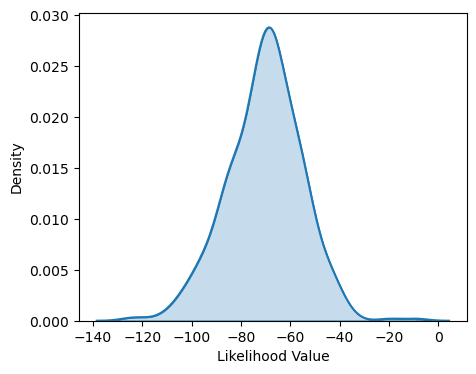

In [63]:
# Set up the matplotlib figure
plt.figure(figsize=(5, 4))

# Draw the density plot
sns.kdeplot(log_likes, fill=True)
#plt.title('Density Plot of Likelihood Values')

kde_line = sns.kdeplot(log_likes).get_lines()[0]
x, y = kde_line.get_data()

# Define the region to fill (from 0 to the max x value)
x_fill = np.linspace(np.max(log_likes), x.max(), 1000)  # 1000 points from 0 to max(x)
y_fill = np.interp(x_fill, x, y)  # Interpolate to find the corresponding y values

# Fill the region under the curve beyond zero with a very faded color
plt.fill_between(x_fill, y_fill, color='black', alpha=0.1)  # You can change 'red' to any color you prefer



plt.xlabel('Likelihood Value')
plt.ylabel('Density')

# Show the plot
plt.show();

## Part of the plot shaded darker, mark the values
## which are not physically present but KDE plot
## made them, so we dont need to worry abut these values

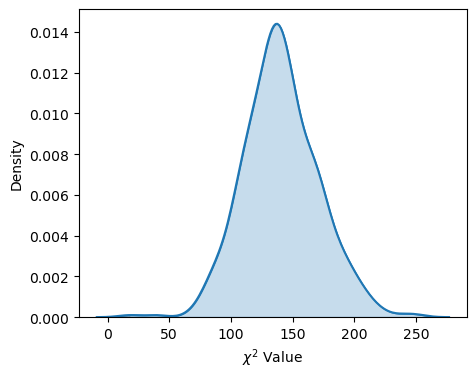

In [64]:
# Set up the matplotlib figure
plt.figure(figsize=(5, 4))

# Draw the density plot
sns.kdeplot(chisq, fill=True)
#plt.title('Density Plot of Likelihood Values')

kde_line = sns.kdeplot(chisq).get_lines()[0]
x, y = kde_line.get_data()


# Define the region to fill (from 0 to the max x value)
x_fill = np.linspace(x.min(), np.min(chisq), 1000)  # 1000 points from 0 to max(x)
y_fill = np.interp(x_fill, x, y)  # Interpolate to find the corresponding y values

# Fill the region under the curve beyond zero with a very faded color
plt.fill_between(x_fill, y_fill, color='black', alpha=0.1)  # You can change 'red' to any color you prefer



plt.xlabel(r'${\chi}^2$ Value')
plt.ylabel('Density')

# Show the plot
plt.show();

# Observations

In [65]:
zdata = []
i = 0
for d in s.data[:]:
    #print(d)
    zdata.append(s.data[i]['z'])
    i+=1

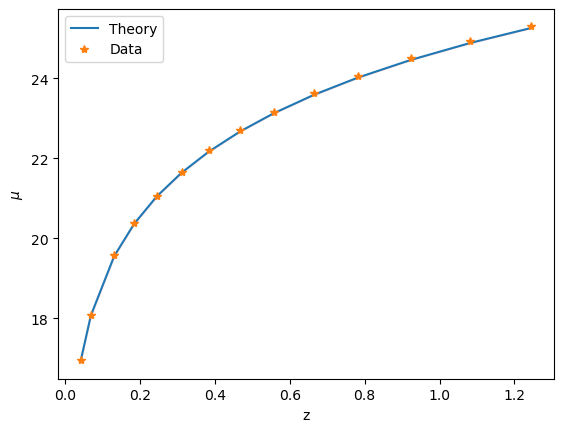

In [66]:
#mu = theory_vectors[1]
# Convert the list of arrays to a 2D array
array_2d = np.vstack(theory_vectors)
#print(array_2d)
# Compute the mean and standard deviation along the columns
means = np.mean(array_2d, axis=0)
stds = np.std(array_2d, axis=0)



f,a2 = plt.subplots()
# Plotting the mean values
plt.plot(zdata, means, label='Theory')
plt.plot(zdata,s.mean,'*',label='Data')
smoothed_lower = get_smoothed_curve(zdata, means, stds, curve_type='lower');
smoothed_upper = get_smoothed_curve(zdata, means, stds, curve_type='upper');
a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='red', alpha=0.1);
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.legend()
plt.show()

# the theory data plotted is the mean row and their is an 
# error band based on the std.

19.303698318286266


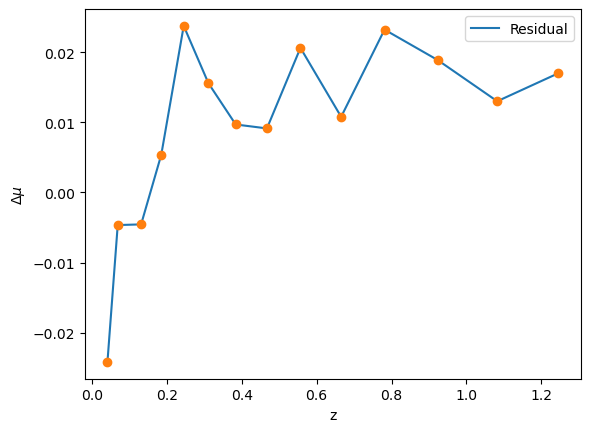

In [69]:
residuals = s.mean - mu
plt.plot(zdata, mu - s.mean,label='Residual')
plt.plot(zdata, mu - s.mean,'o')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$\Delta \mu$')

# Computing by hand
cov = s.covariance.dense
cholesky = scipy.linalg.cholesky(cov, lower=True)
inv_cov = np.linalg.inv(cov)
x = scipy.linalg.solve_triangular(cholesky, residuals, lower=True)
chisqr = np.dot(x, x)
print(chisqr)